In [1]:
from JavaClones.Vec2 import Vec2
from Plotting.Plotter import PlotType, Plotter

In [2]:
v_max = 2.0
a_max = 3.0

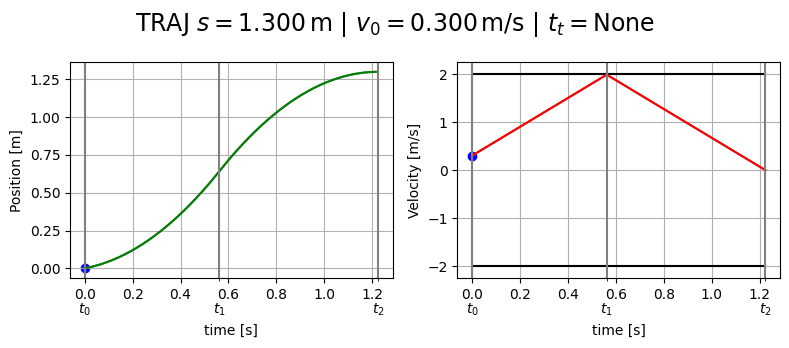

In [3]:
Plotter.plot(
    s0=0.2,
    s1=1.5,
    v0=0.3,
    v_max=v_max,
    a_max=a_max,
    tt=None,
    primary_direction=None,
    plot_type=PlotType.TRAJ_NO_ACC,
    save_fig=False,
    show_fig=True
)

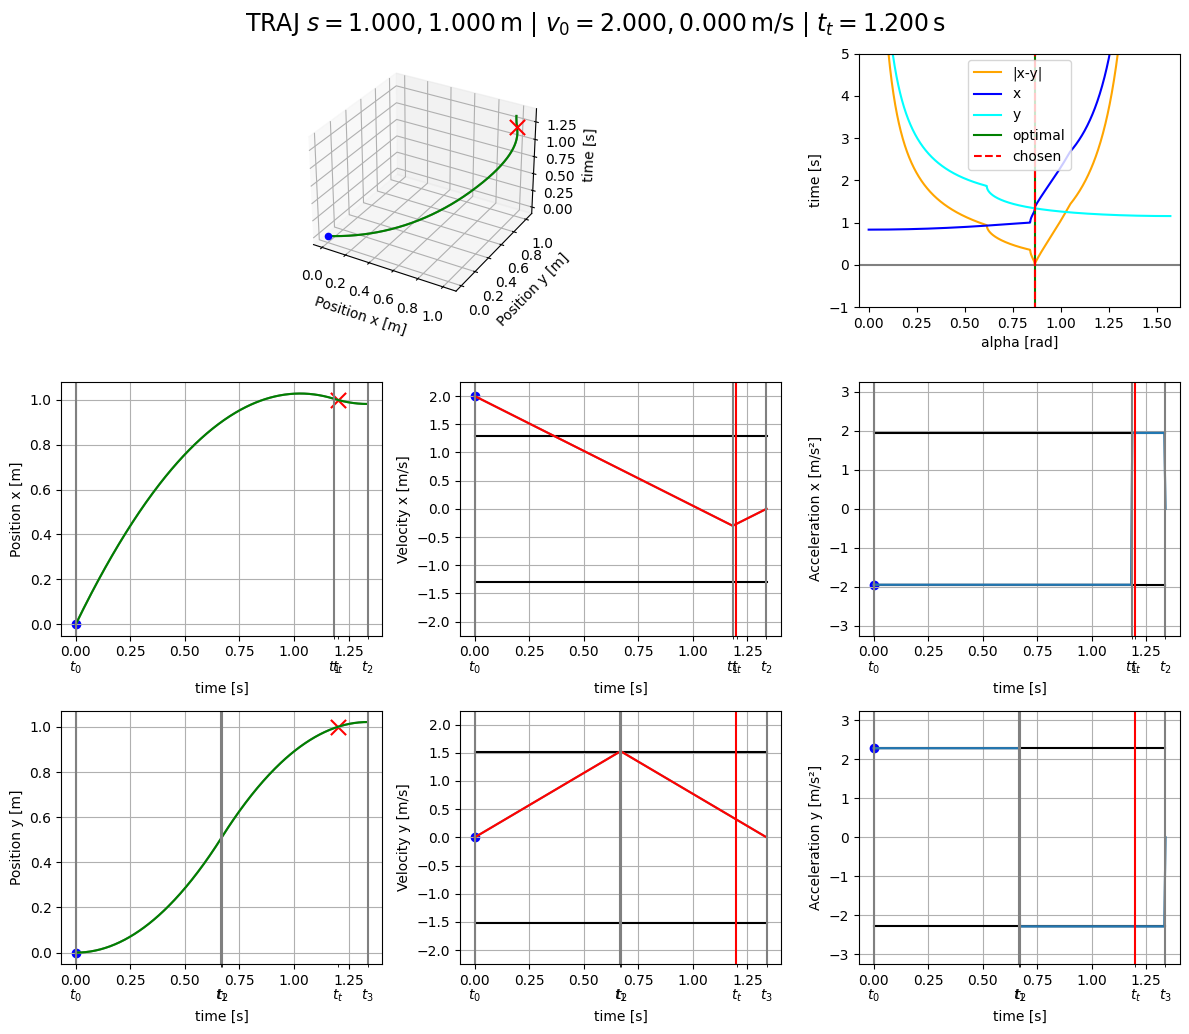

In [4]:
Plotter.plot(
    s0=Vec2.zero(),
    s1=Vec2(1.0, 1.0),
    v0=Vec2(v_max, 0.0),
    v_max=v_max,
    a_max=a_max,
    tt=1.2,
    primary_direction=None,
    plot_type=PlotType.TRAJ,
    save_fig=False,
    show_fig=True
)

2.000, 0.500
4.440892098500626e-16
1.888, 0.399
0.15064655604570554


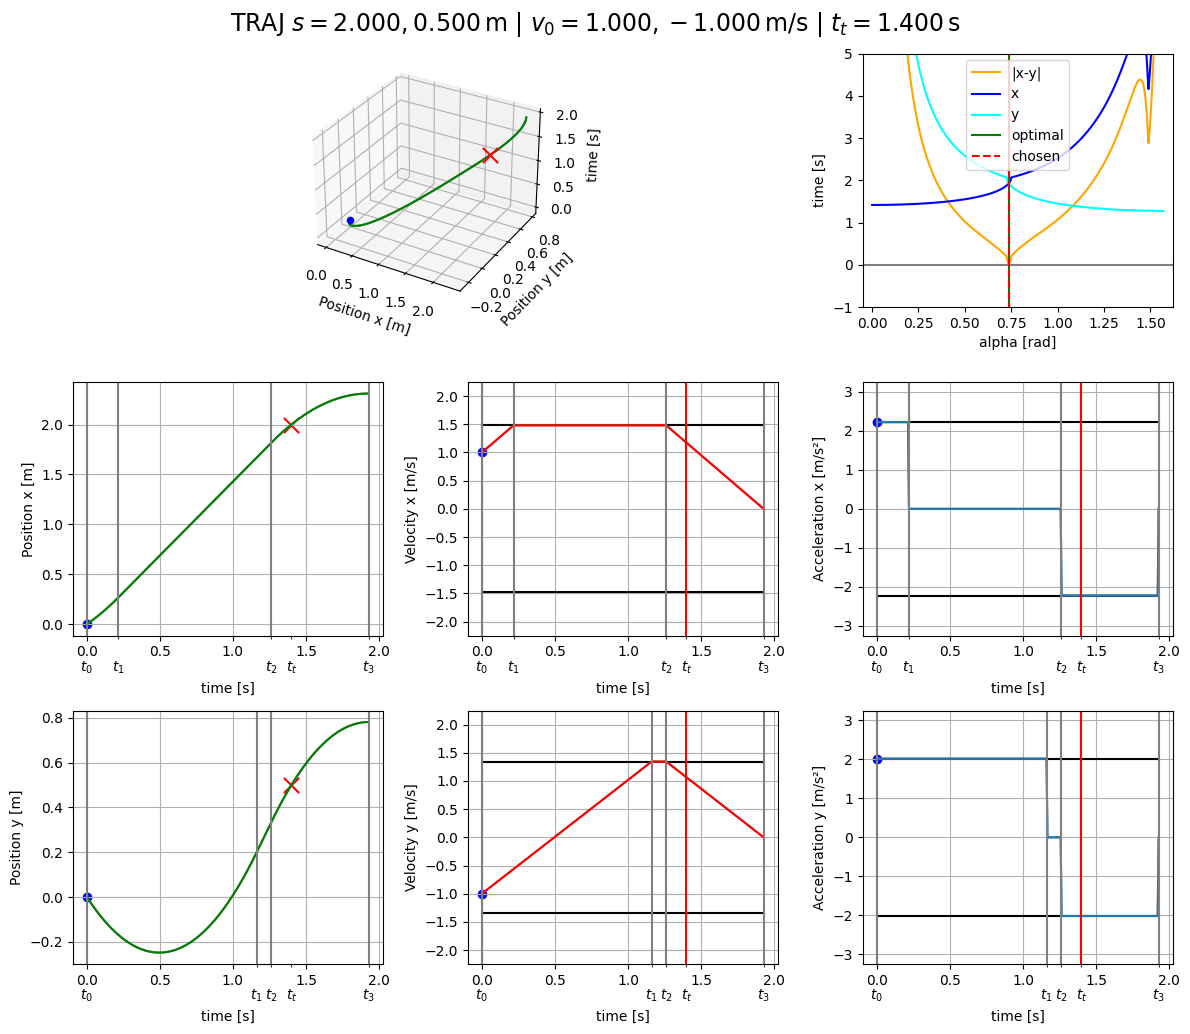

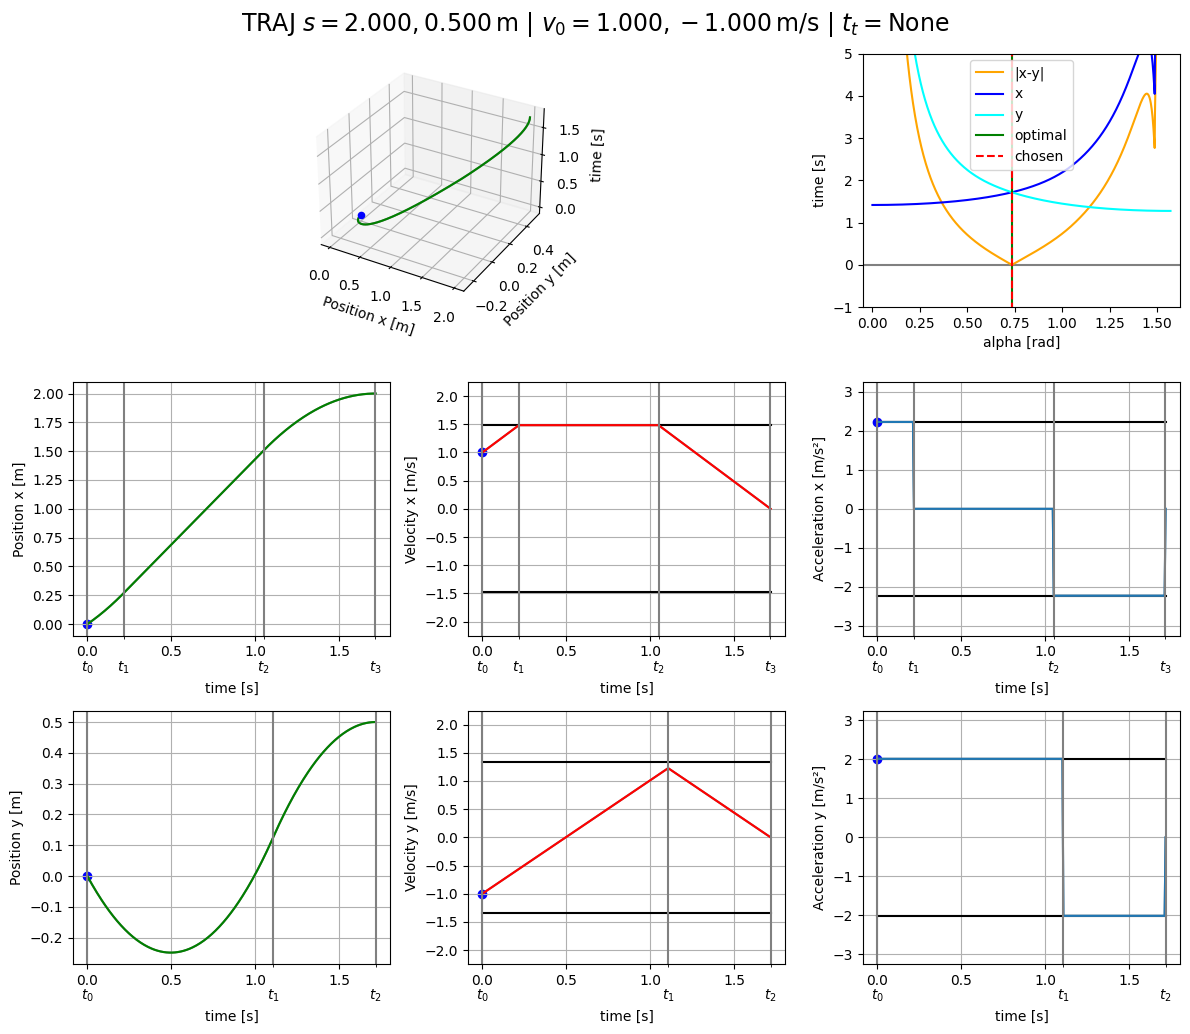

In [5]:
distances = [Vec2(2, 0.5)]
initial_velocities = [Vec2(1, -1)]
target_times = [1.4, None]



for d in sorted(set(distances)):
    for i_v in sorted(set(initial_velocities)):
        for tt in set(target_times):
            pos = Plotter.plot(
                s0=Vec2.zero(),
                s1=d,
                v0=i_v,
                v_max=v_max,
                a_max=a_max,
                tt=tt,
                primary_direction=None,
                plot_type=PlotType.TRAJ,
                save_fig=True,
                show_fig=True
            ).get_position(1.4)
            print(pos)
            print((pos-Vec2(2,.5)).get_length())

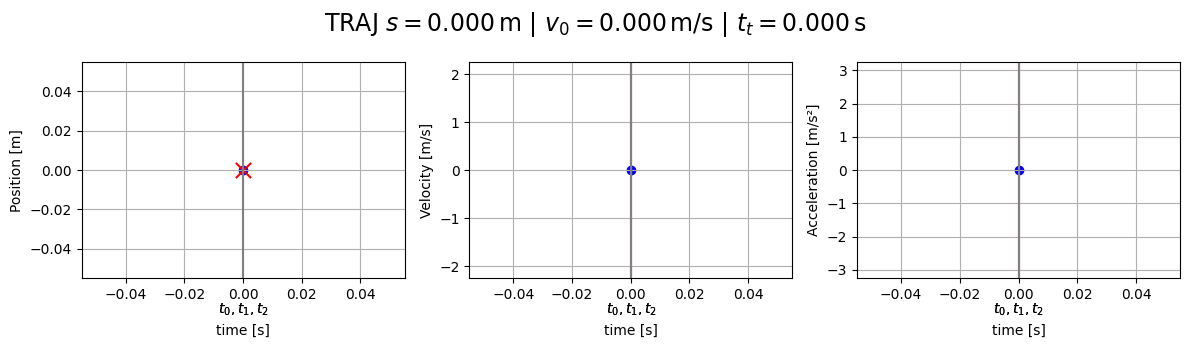

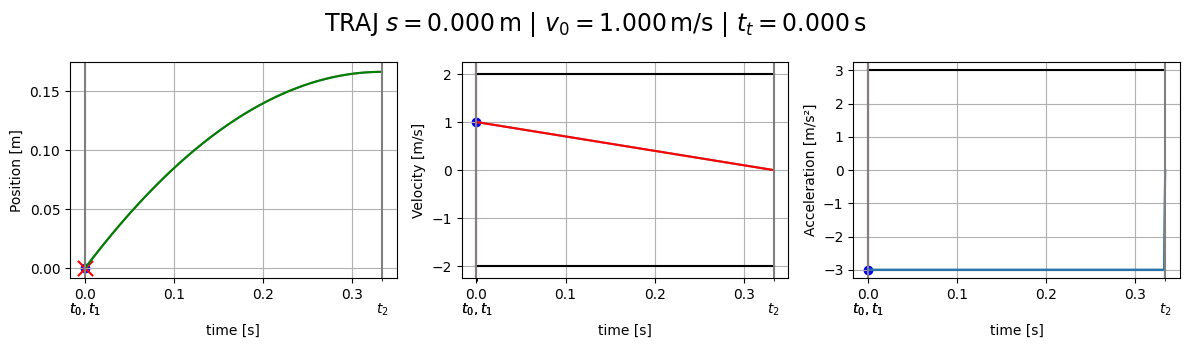

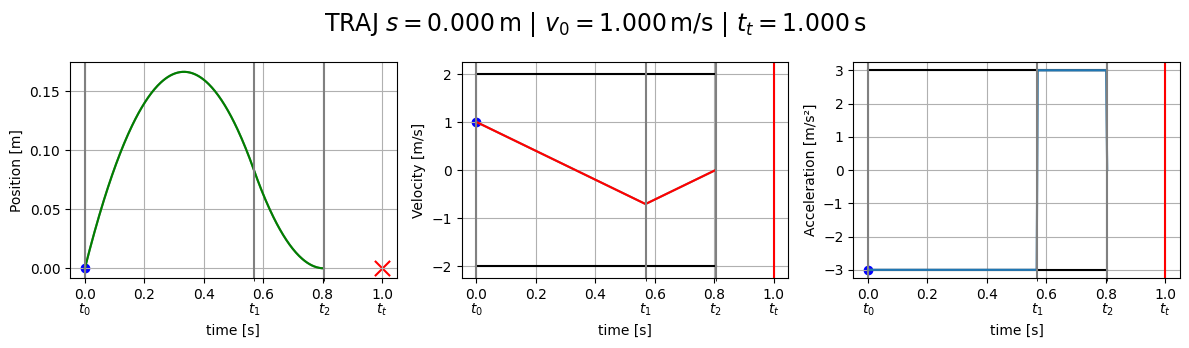

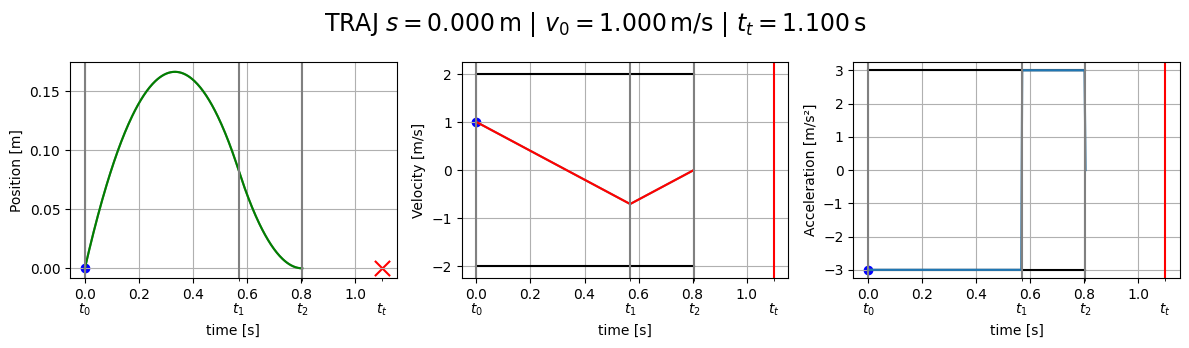

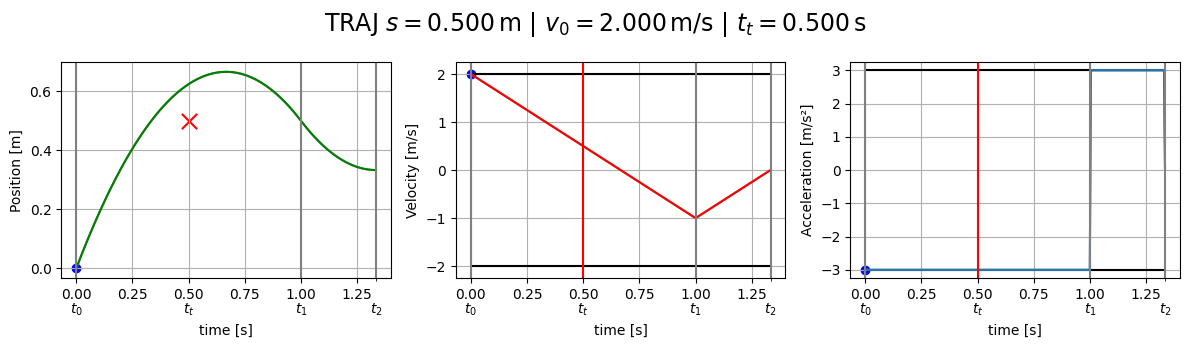

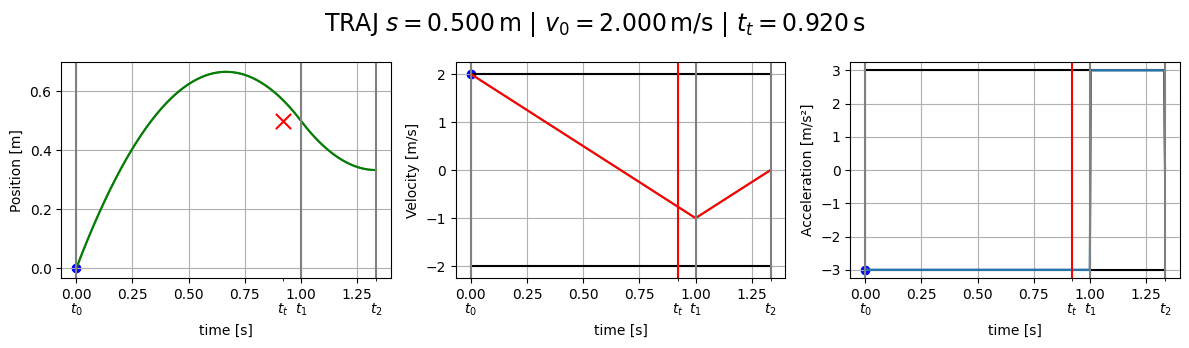

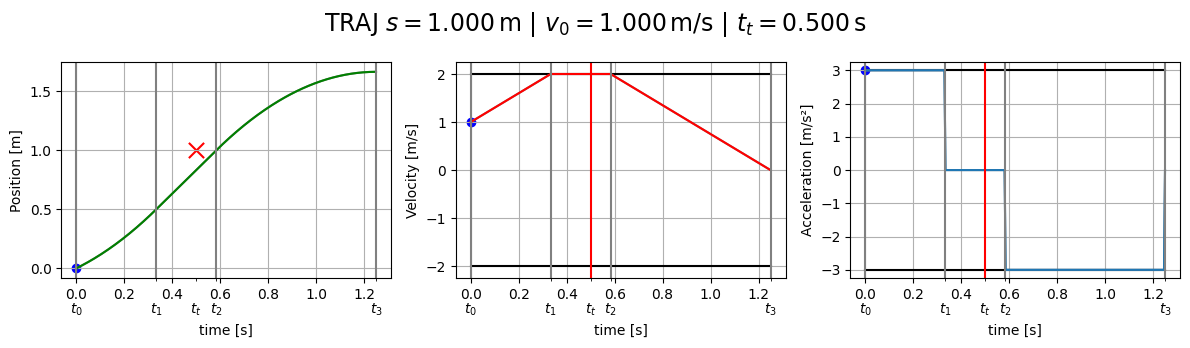

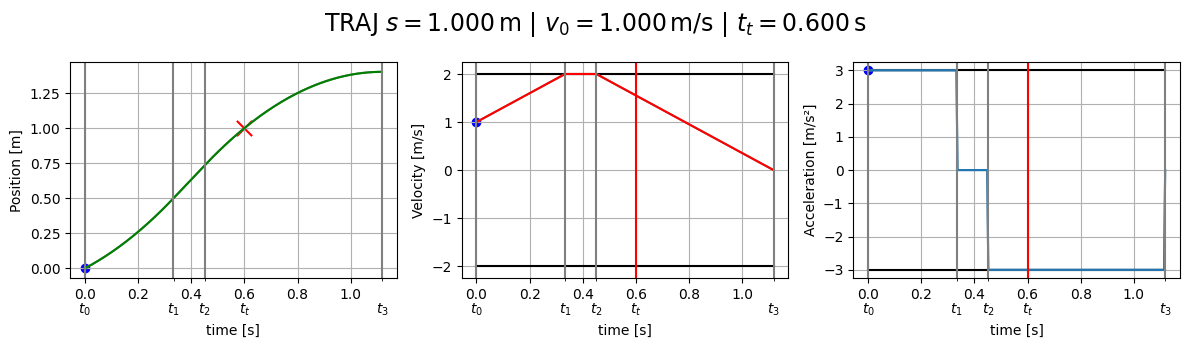

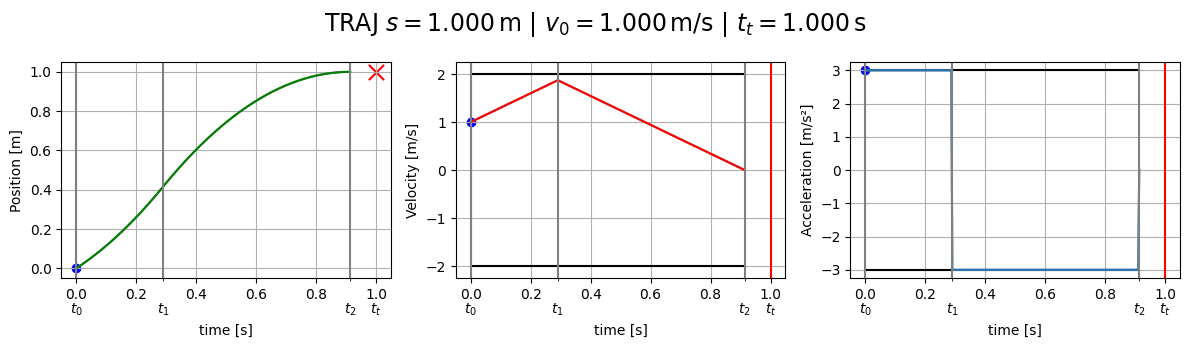

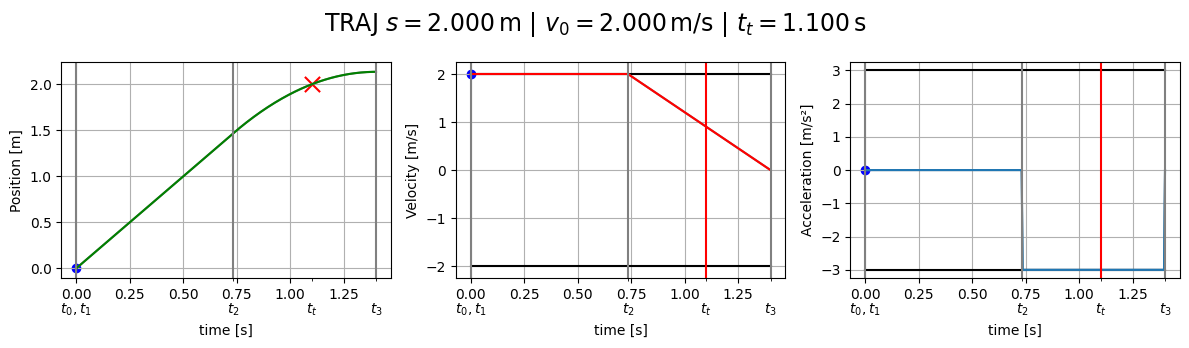

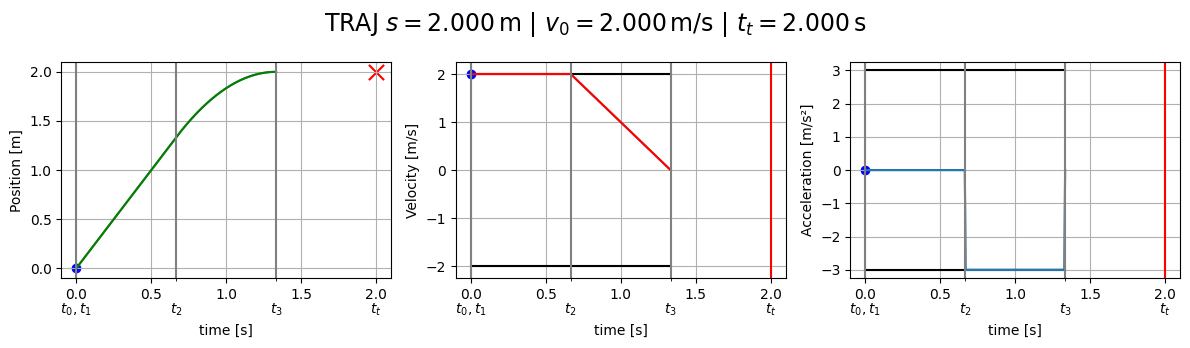

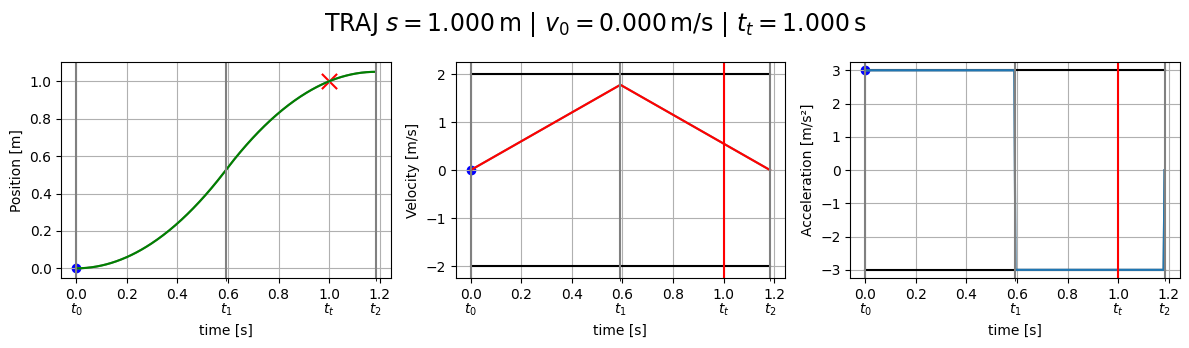

In [6]:
test_values = [
    (0.0, 0.0, 0.0),
    (0.0, 1.0, 0.0),
    (0.0, 1.0, 1.0),
    (0.0, 1.0, 1.1),
    (0.5, 2.0, 0.5),
    (0.5, 2.0, 0.92),
    (1.0, 1.0, 0.5),
    (1.0, 1.0, 0.6),
    (1.0, 1.0, 1.0),
    (2.0, 2.0, 1.1),
    (2.0, 2.0, 2.0),
    (1.0, 0.0, 1.0),
]

for values in test_values:
    Plotter.plot(
        s0=0,
        s1=values[0],
        v0=values[1],
        v_max=v_max,
        a_max=a_max,
        tt=values[2],
        primary_direction=None,
        plot_type=PlotType.TRAJ,
        save_fig=False,
        show_fig=True
    )

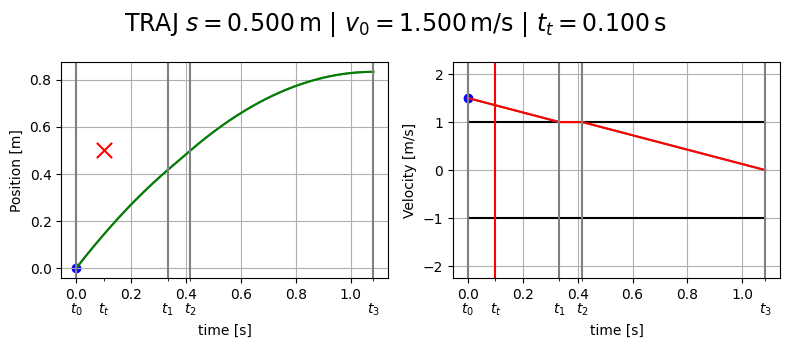

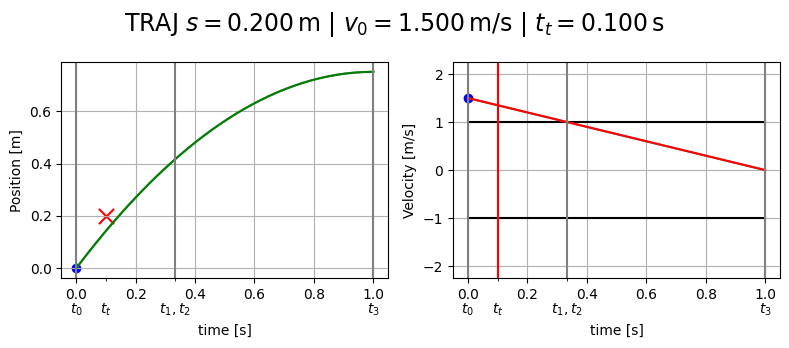

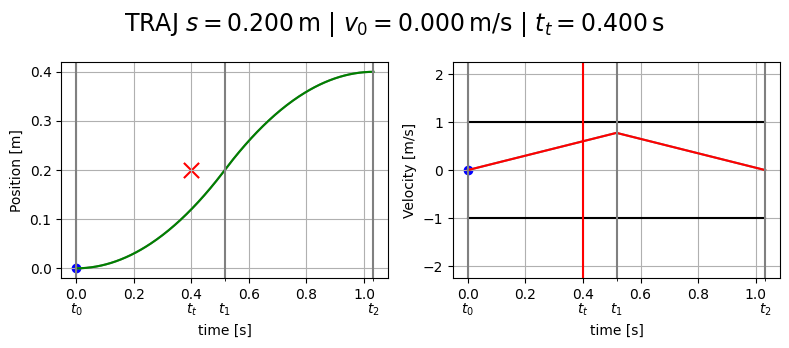

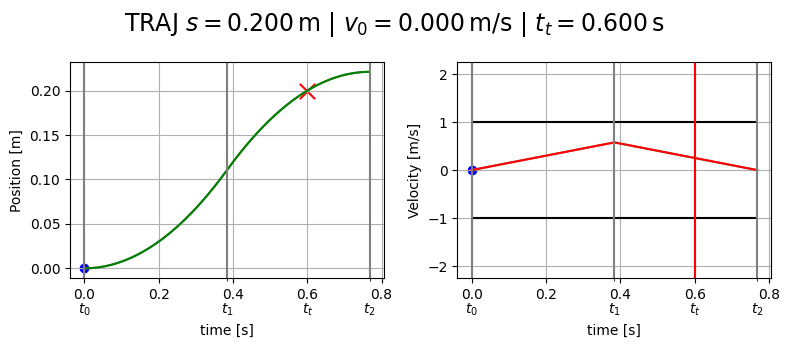

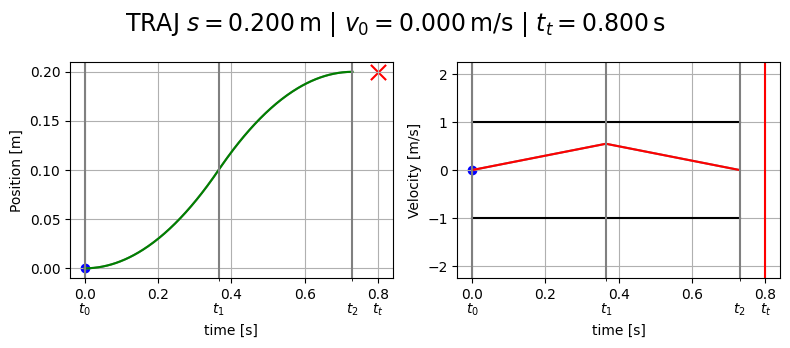

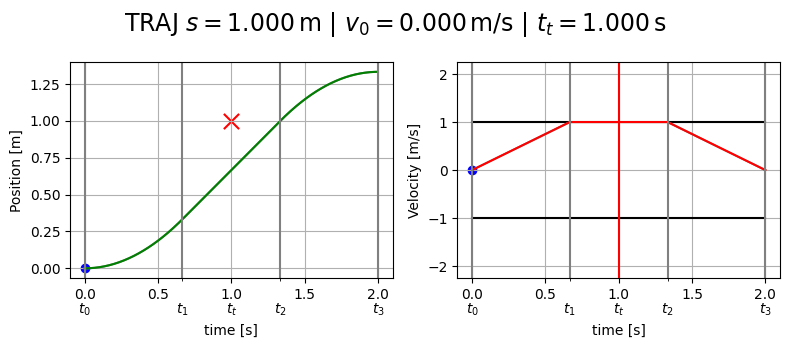

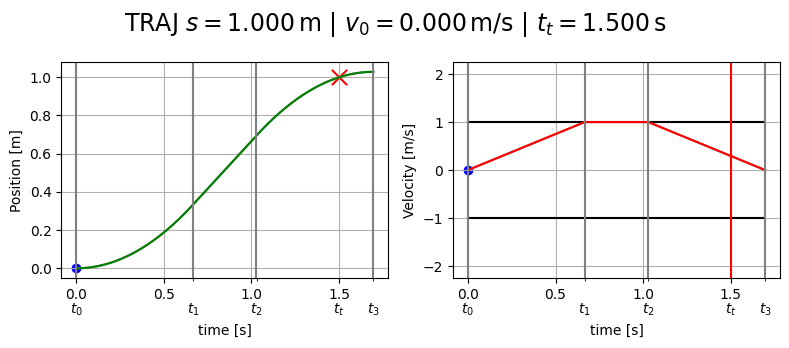

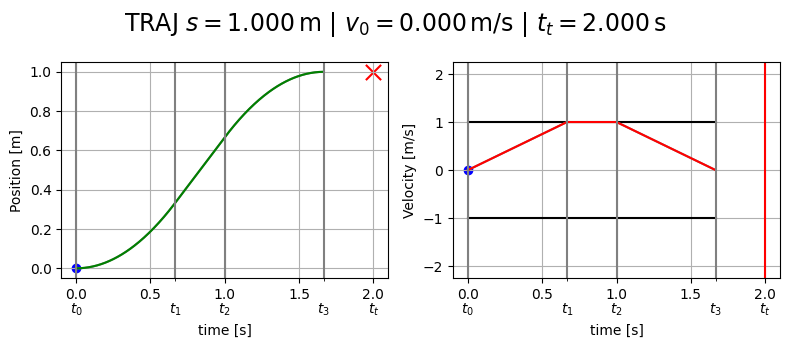

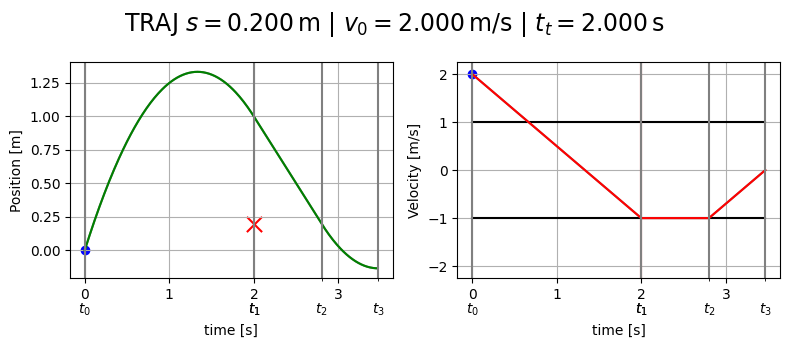

In [7]:
test_values = [
    (0.5, 1.5, 0.1, "trap_too_slow_2.svg"),
    (0.2, 1.5, 0.1, "line_too_slow.svg"),
    (0.2, 0, 0.4, "tria_too_slow.svg"),
    (0.2, 0, 0.6, "tria_direct.svg"),
    (0.2, 0, 0.8, "tria_early.svg"),
    (1, 0, 1, "trap_too_slow_1.svg"),
    (1, 0, 1.5, "trap_direct.svg"),
    (1, 0, 2, "trap_early.svg"),
    (0.2, 2, 2, "overshoot.svg"),
]

for values in test_values:
    Plotter.plot(
        s0=0,
        s1=values[0],
        v0=values[1],
        v_max=v_max,
        a_max=a_max,
        tt=values[2],
        primary_direction=None,
        plot_type=PlotType.TRAJ_NO_ACC,
        save_fig=values[3],
        show_fig=True,
        v_max_1d=1,
        a_max_1d=1.5,
    )

Total times:
2.194
2.406

Angles [deg]:
81.0
78.0

Max Vel and Max Acc:
0.314, 0.471
0.414, 0.621


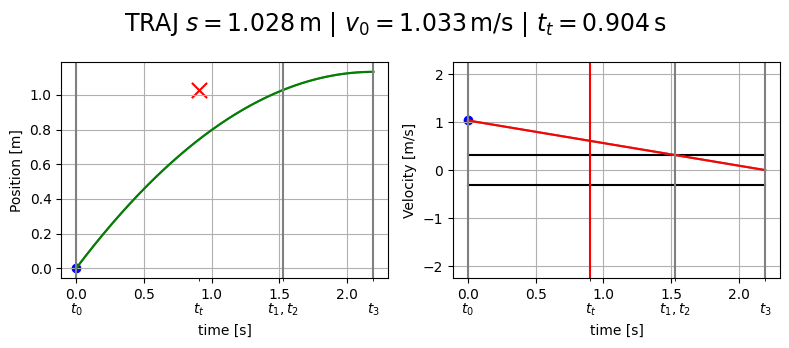

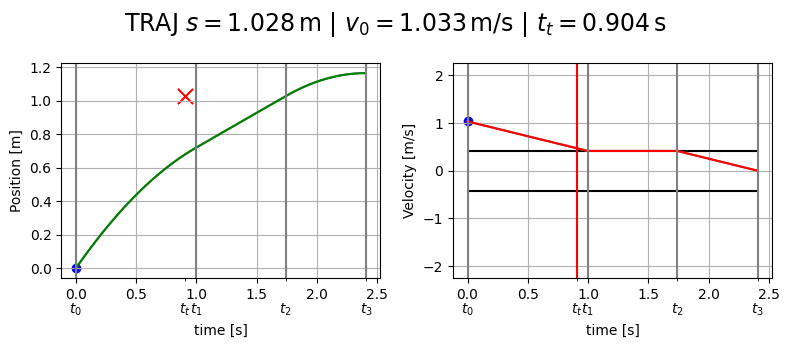

In [8]:
import math

s = 1.028468852217555351558075926732271909713745117187500000000000
v0 = 1.032920985147269377080192498397082090377807617187500000000000
factor = 0.1467304745
factor1 = factor + 0.0102
factor2 = factor + 0.0604
tt = 0.903802978547136981468668182060355320572853088378906250000000
print("Total times:")
print("{:.3f}".format(Plotter.plot(
    s0=0,
    s1=s,
    v0=v0,
    v_max=v_max,
    a_max=a_max,
    tt=tt,
    primary_direction=None,
    plot_type=PlotType.TRAJ_NO_ACC,
    v_max_1d=v_max * factor1,
    a_max_1d=a_max * factor1,
    save_fig="none_convexity_1.svg"
).get_total_time()))
print("{:.3f}".format(Plotter.plot(
    s0=0,
    s1=s,
    v0=v0,
    v_max=v_max,
    a_max=a_max,
    tt=tt,
    primary_direction=None,
    plot_type=PlotType.TRAJ_NO_ACC,
    v_max_1d=v_max * factor2,
    a_max_1d=a_max * factor2,
    save_fig="none_convexity_2.svg"
).get_total_time()))
print()
print("Angles [deg]:")
print(f"{math.acos(factor1) * 180 / math.pi:.1f}")
print(f"{math.acos(factor2) * 180 / math.pi:.1f}")
print()
print("Max Vel and Max Acc:")
print(f"{v_max * factor1:.3f}, {a_max * factor1:.3f}")
print(f"{v_max * factor2:.3f}, {a_max * factor2:.3f}")

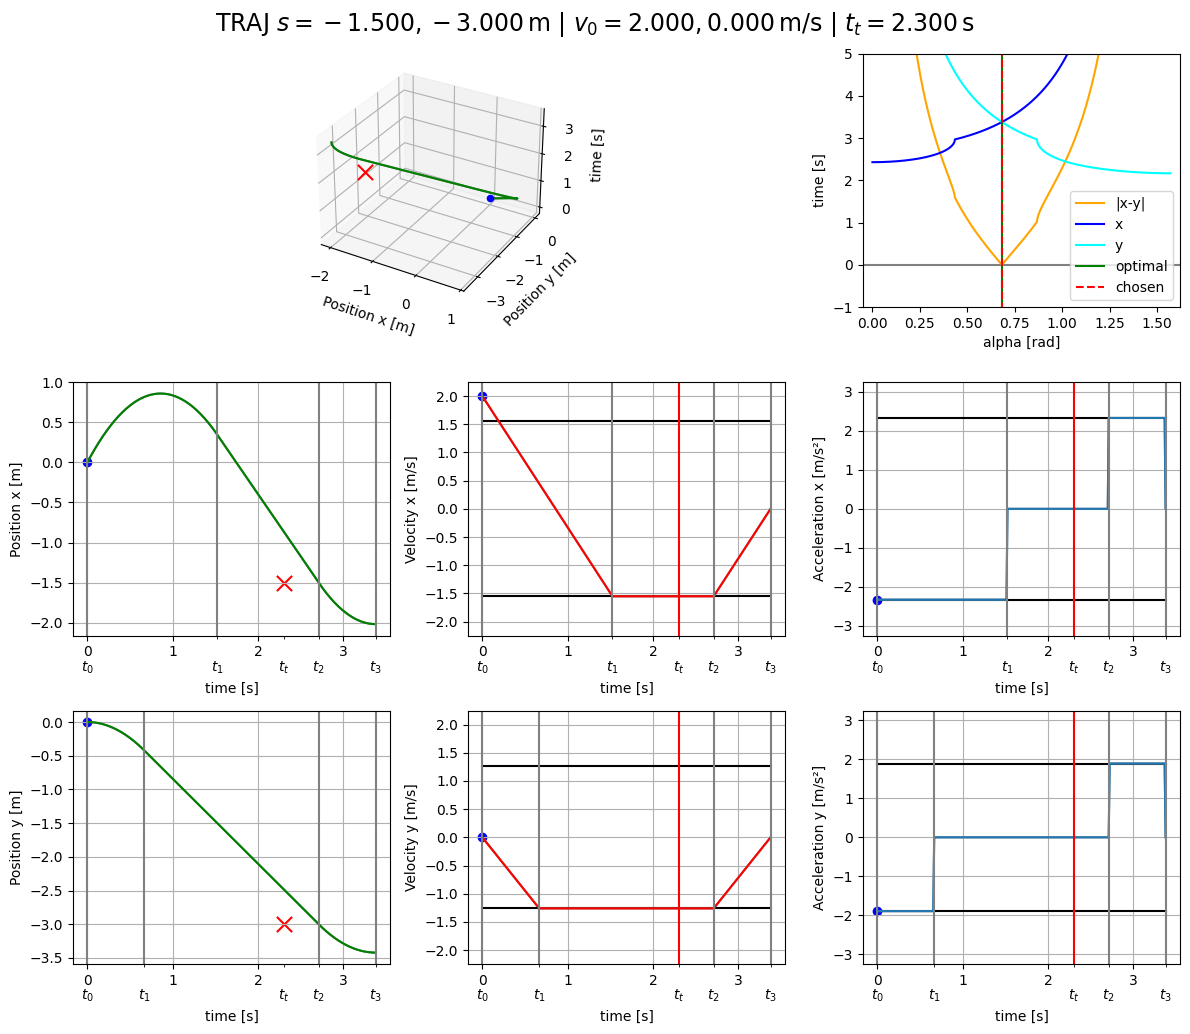

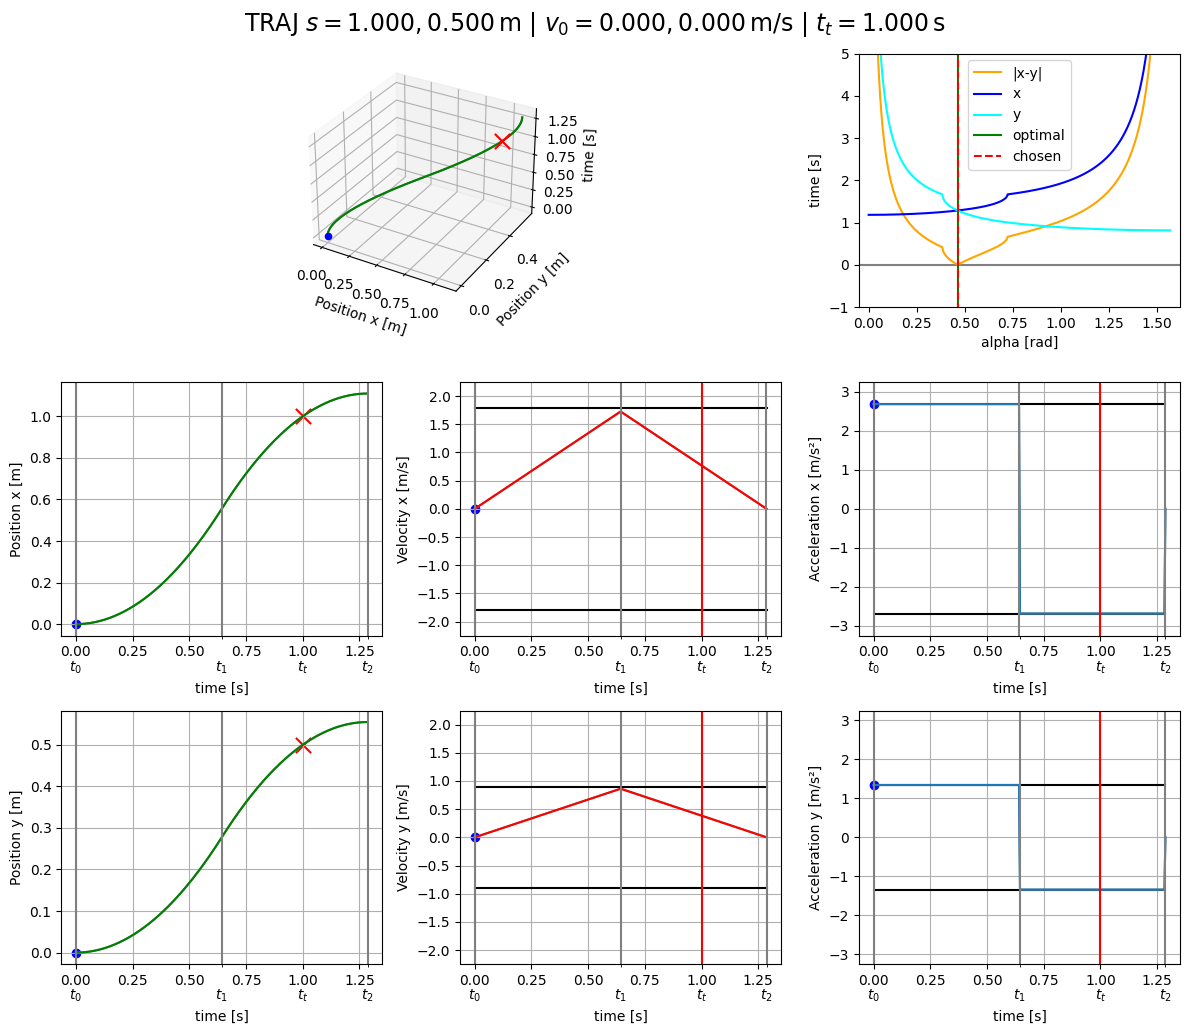

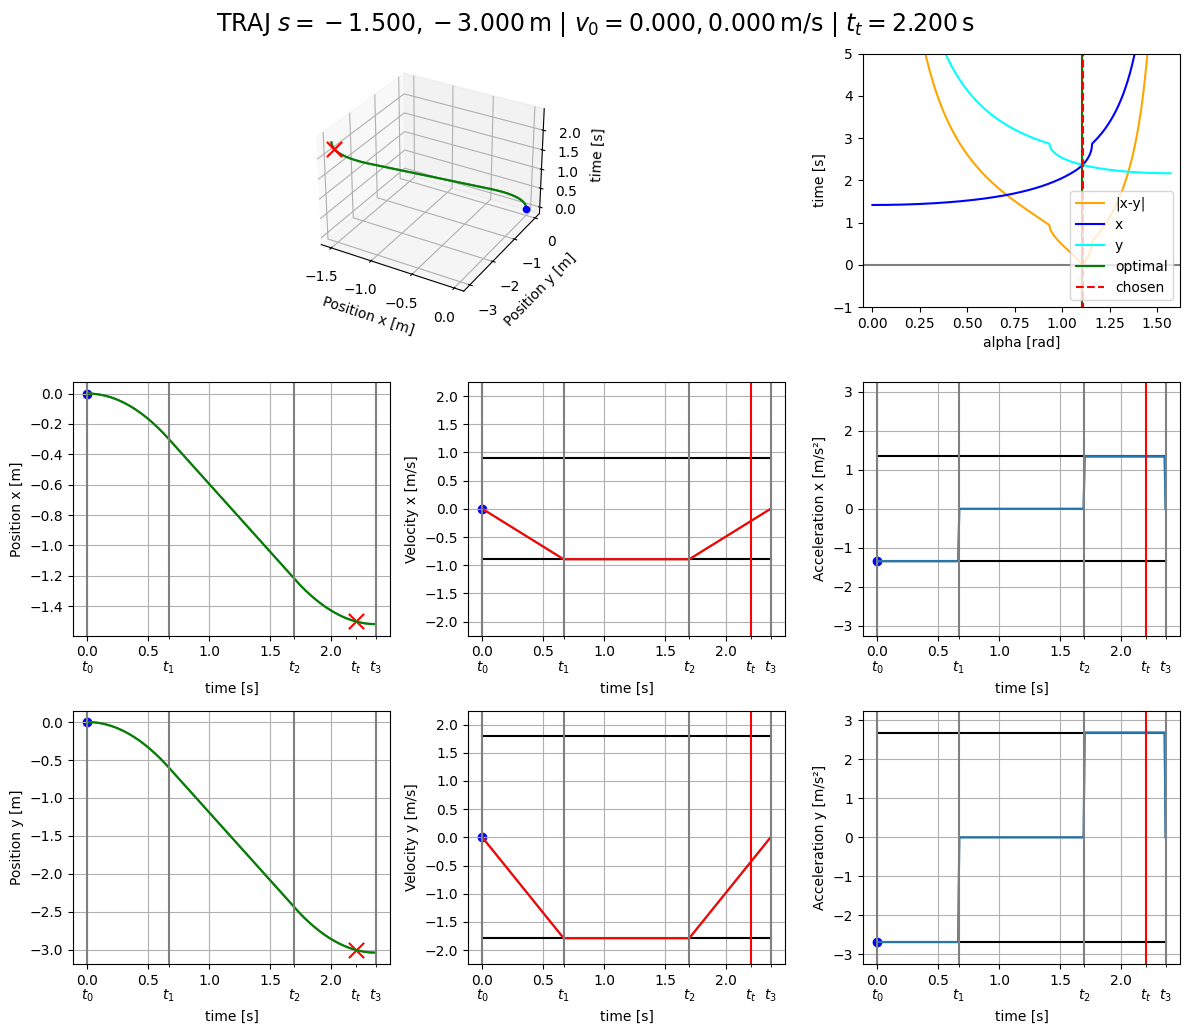

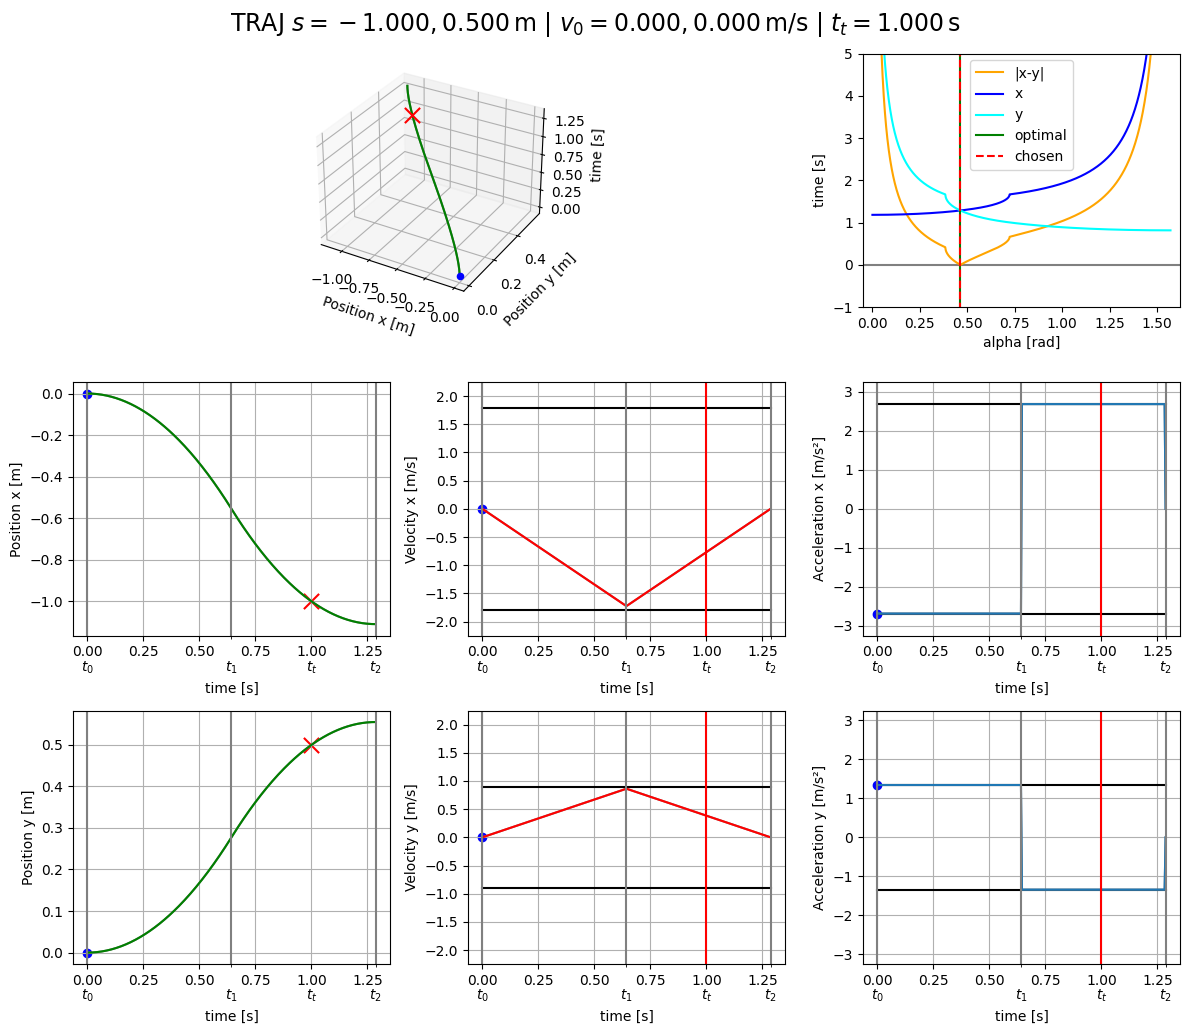

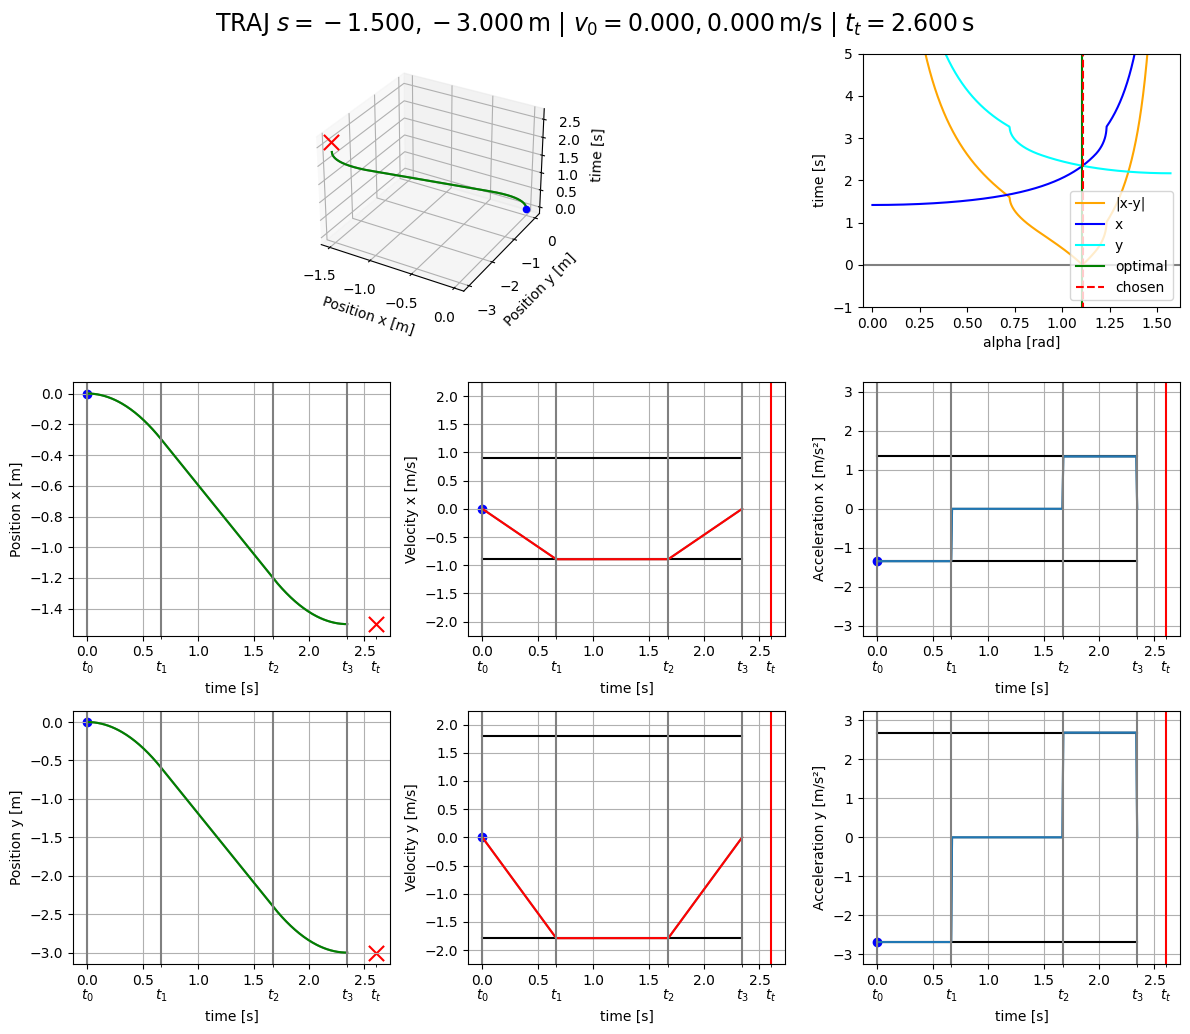

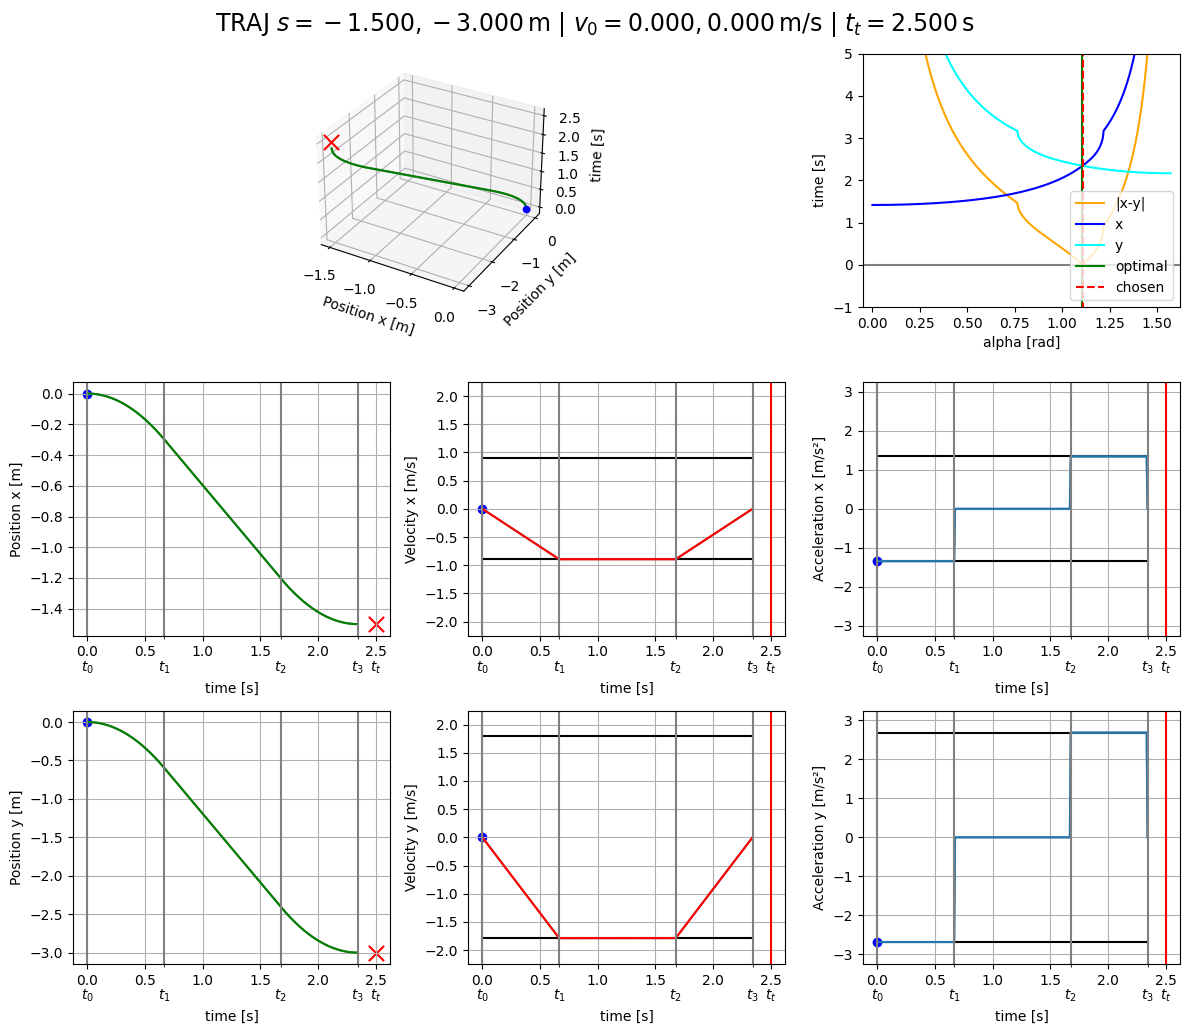

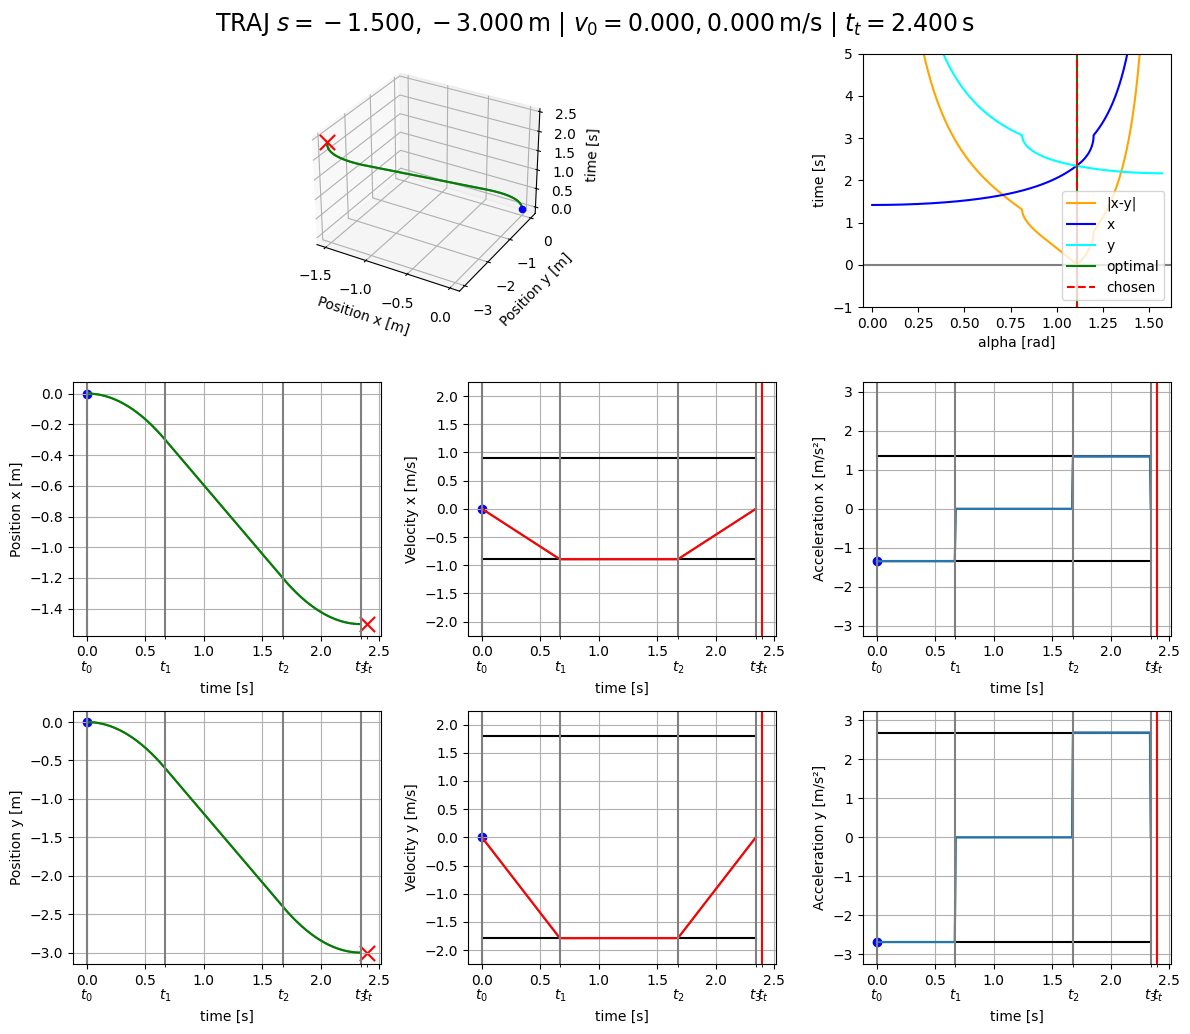

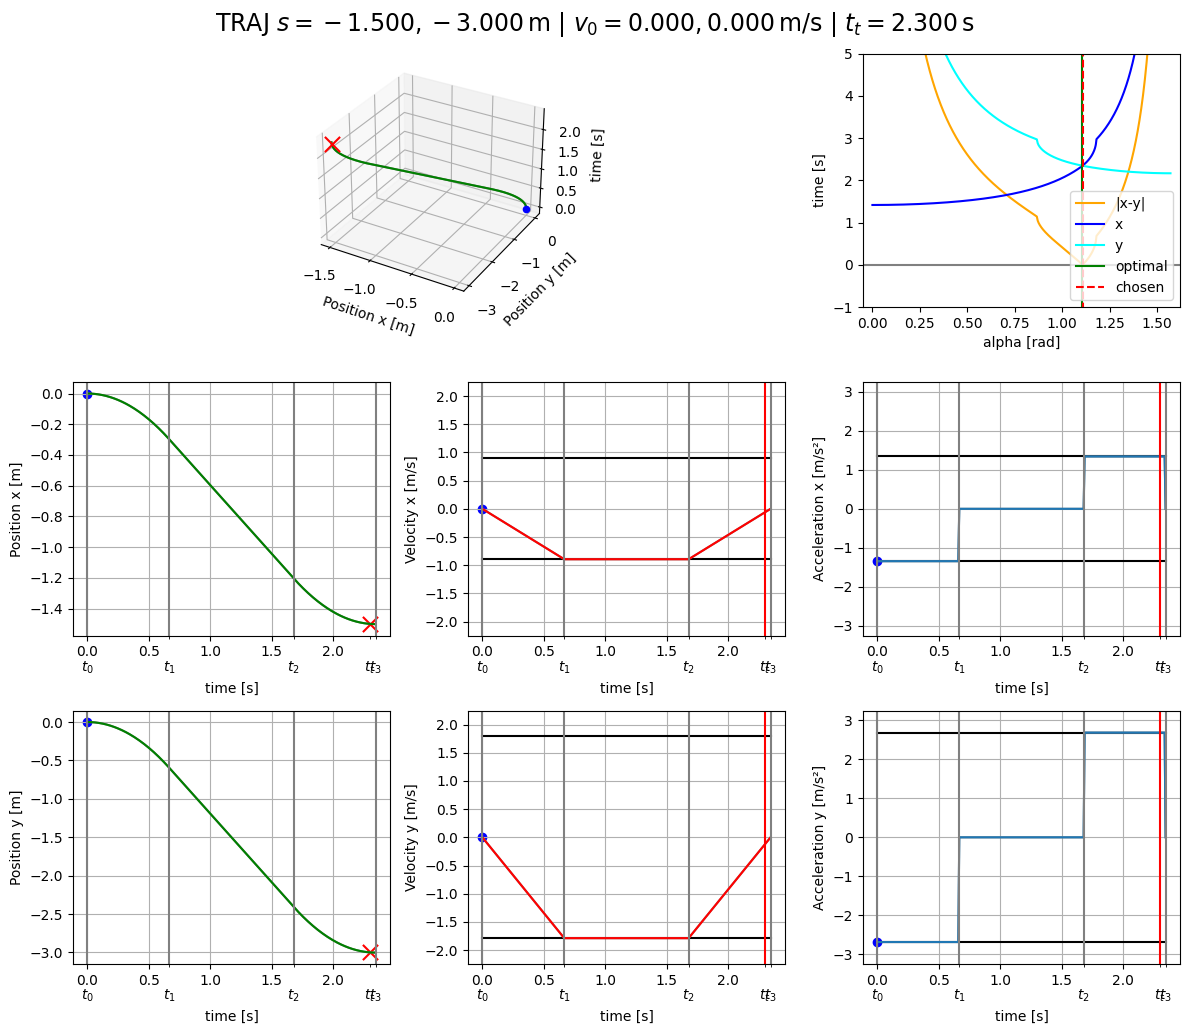

In [9]:
test_values = [
    ((-1.5, -3), (2, 0), 2.3),
    ((1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.2),
    ((-1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.6),
    ((-1.5, -3), (0, 0), 2.5),
    ((-1.5, -3), (0, 0), 2.4),
    ((-1.5, -3), (0, 0), 2.3),
]

for values in test_values:
    Plotter.plot(
        s0=0,
        s1=Vec2(*values[0]),
        v0=Vec2(*values[1]),
        v_max=v_max,
        a_max=a_max,
        tt=values[2],
        primary_direction=None,
        plot_type=PlotType.TRAJ,
        save_fig=False,
        show_fig=True
    )

In [10]:
from JavaClones.DestinationForTimedPositionCalc import DestinationForTimedPositionCalc
from JavaClones.BangBangTrajectoryFactory import BangBangTrajectoryFactory

shifter = DestinationForTimedPositionCalc()
factory = BangBangTrajectoryFactory()

tt = 0.75
distance = 0
while True:
    traj = factory.traj_2d_sync(s0=Vec2.zero(), s1=Vec2(distance,0),v0=Vec2.zero(), v_max=v_max, a_max=a_max)
    if (traj.get_position(tt)-Vec2(distance,0)).get_length() <= 0.001:
        distance += 0.001
    else:
        print(f"Radius without overshoot: {distance:.3f} m")
        distance = 0
        break
while True:
    dest,_ = shifter.destination_for_bang_bang_2d_sync(s0=Vec2.zero(), s1=Vec2(distance, 0), v0=Vec2.zero(), v_max=v_max, a_max=a_max, tt=tt)
    traj = factory.traj_2d_sync(s0=Vec2.zero(), s1=dest,v0=Vec2.zero(), v_max=v_max, a_max=a_max)
    if (traj.get_position(tt)-Vec2(distance,0)).get_length() <= 0.001:
        distance += 0.001
    else:
        time_no_overshoot = factory.traj_2d_sync(s0=Vec2.zero(), s1=Vec2(distance,0), v0=Vec2.zero(), v_max=v_max, a_max=a_max).get_total_time()
        print(f"   Radius with overshoot: {distance:.3f} m")
        print(f"  Time without overshoot: {time_no_overshoot:.3f} s")
        print(f"                    diff: {time_no_overshoot-tt:.3f} s")
        distance = 0
        break

Radius without overshoot: 0.452 m
   Radius with overshoot: 0.835 m
  Time without overshoot: 1.055 s
                    diff: 0.305 s
